<a href="https://colab.research.google.com/github/Mohan0332/Capstone/blob/main/img_aug_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

from keras.datasets import mnist
from keras.layers import Dense, Flatten, Reshape
from keras.layers import LeakyReLU
from keras.models import Sequential
from keras.optimizers import Adam

In [ ]:
img_rows = 28
img_cols = 28
channels = 1

# Input image dimensions
img_shape = (img_rows, img_cols, channels)

# Size of the noise vector, used as input to the Generator
z_dim = 100

In [ ]:
def build_generator(img_shape, z_dim):

    model = Sequential()

    # Fully connected layer
    model.add(Dense(128, input_dim=z_dim))

    # Leaky ReLU activation
    model.add(LeakyReLU(alpha=0.01))

    # Output layer with tanh activation
    model.add(Dense(28 * 28 * 1, activation='tanh'))

    # Reshape the Generator output to image dimensions
    model.add(Reshape(img_shape))

    return model

In [ ]:
def build_discriminator(img_shape):

    model = Sequential()

    # Flatten the input image
    model.add(Flatten(input_shape=img_shape))

    # Fully connected layer
    model.add(Dense(128))

    # Leaky ReLU activation
    model.add(LeakyReLU(alpha=0.01))

    # Output layer with sigmoid activation
    model.add(Dense(1, activation='sigmoid'))

    return model

In [ ]:
def build_gan(generator, discriminator):

    model = Sequential()

    # Combined Generator -> Discriminator model
    model.add(generator)
    model.add(discriminator)

    return model

In [ ]:
# Build and compile the Discriminator
discriminator = build_discriminator(img_shape)
discriminator.compile(loss='binary_crossentropy',
                      optimizer=Adam(),
                      metrics=['accuracy'])

# Build the Generator
generator = build_generator(img_shape, z_dim)

# Keep Discriminator’s parameters constant for Generator training
discriminator.trainable = False

# Build and compile GAN model with fixed Discriminator to train the Generator
gan = build_gan(generator, discriminator)
gan.compile(loss='binary_crossentropy', optimizer=Adam())

In [ ]:
losses = []
accuracies = []
iteration_checkpoints = []


def train(iterations, batch_size, sample_interval):

    # Load the MNIST dataset
    (X_train, _), (_, _) = mnist.load_data()

    # Rescale [0, 255] grayscale pixel values to [-1, 1]
    X_train = X_train / 127.5 - 1.0
    X_train = np.expand_dims(X_train, axis=3)

    # Labels for real images: all ones
    real = np.ones((batch_size, 1))

    # Labels for fake images: all zeros
    fake = np.zeros((batch_size, 1))

    for iteration in range(iterations):

        # -------------------------
        #  Train the Discriminator
        # -------------------------

        # Get a random batch of real images
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        imgs = X_train[idx]

        # Generate a batch of fake images
        z = np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = generator.predict(z)

        # Train Discriminator
        d_loss_real = discriminator.train_on_batch(imgs, real)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
        d_loss, accuracy = 0.5 * np.add(d_loss_real, d_loss_fake)

        # ---------------------
        #  Train the Generator
        # ---------------------

        # Generate a batch of fake images
        z = np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = generator.predict(z)

        # Train Generator
        g_loss = gan.train_on_batch(z, real)

        if (iteration + 1) % sample_interval == 0:

            # Save losses and accuracies so they can be plotted after training
            losses.append((d_loss, g_loss))
            accuracies.append(100.0 * accuracy)
            iteration_checkpoints.append(iteration + 1)

            # Output training progress
            print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" %
                  (iteration + 1, d_loss, 100.0 * accuracy, g_loss))

            # Output a sample of generated image
            sample_images(generator)

In [ ]:


def sample_images(generator, image_grid_rows=4, image_grid_columns=4):

    # Sample random noise
    z = np.random.normal(0, 1, (image_grid_rows * image_grid_columns, z_dim))

    # Generate images from random noise
    gen_imgs = generator.predict(z)

    # Rescale image pixel values to [0, 1]
    gen_imgs = 0.5 * gen_imgs + 0.5

    # Set image grid
    fig, axs = plt.subplots(image_grid_rows,
                            image_grid_columns,
                            figsize=(4, 4),
                            sharey=True,
                            sharex=True)

    cnt = 0
    for i in range(image_grid_rows):
        for j in range(image_grid_columns):
            # Output a grid of images
            axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
            axs[i, j].axis('off')
            cnt += 1



Streaming output truncated to the last 5000 lines.
4/4 [==============================] - 0s 6ms/step
18000 [D loss: 0.267511, acc.: 89.45%] [G loss: 2.786061]
4/4 [==============================] - 0s 4ms/step
19000 [D loss: 0.532720, acc.: 73.83%] [G loss: 2.055741]
4/4 [==============================] - 0s 5ms/step
20000 [D loss: 0.505993, acc.: 77.34%] [G loss: 1.989295]
1/1 [==============================] - 0s 31ms/step


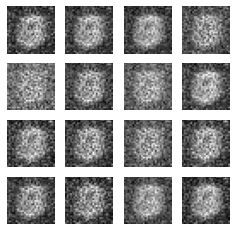

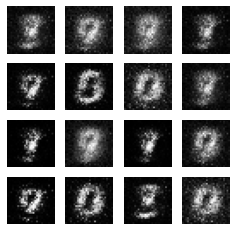

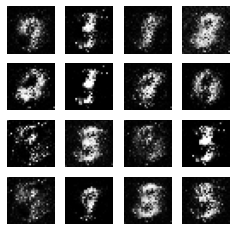

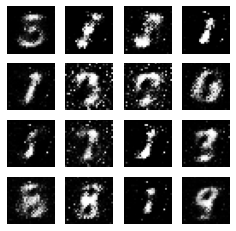

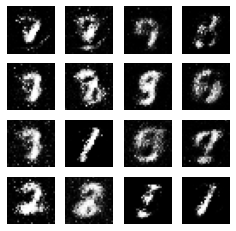

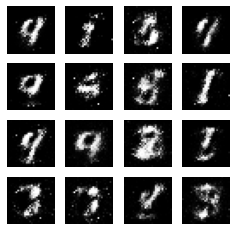

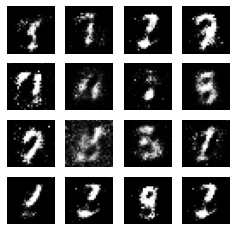

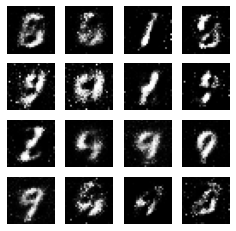

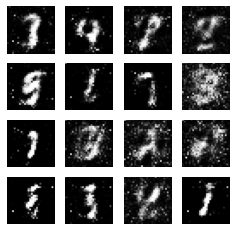

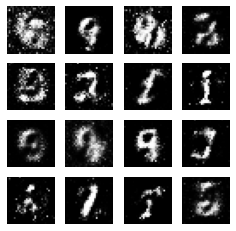

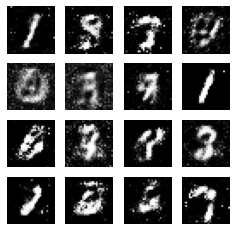

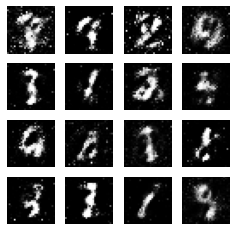

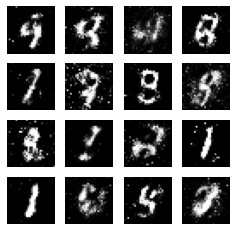

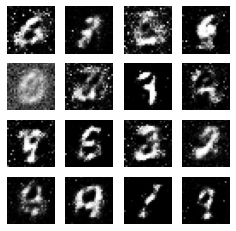

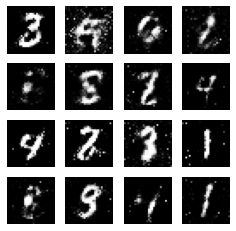

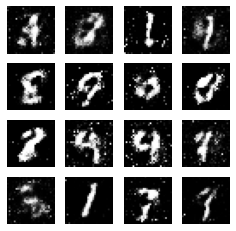

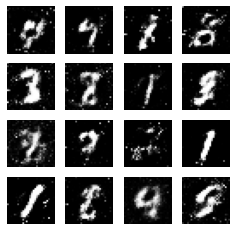

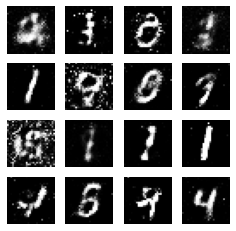

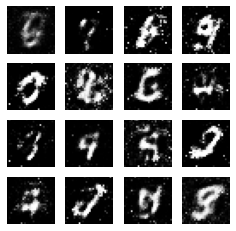

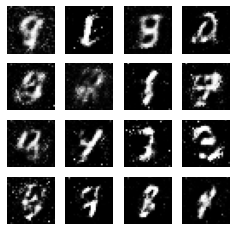

In [31]:
# Set hyperparameters
iterations = 20000
batch_size = 128
sample_interval = 1000

# Train the GAN for the specified number of iterations
train(iterations, batch_size, sample_interval)